# Librerias, semilla y funciones 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
import sys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm


from sklearn.metrics import accuracy_score, balanced_accuracy_score,average_precision_score, precision_recall_curve, roc_curve, auc, recall_score, precision_score, confusion_matrix, f1_score



### Constantes:
seed=123


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
sys.path.append('../src')
import funciones as f
sys.path.remove('../src')

In [3]:
df_train = pd.read_csv('../data/df_train_scaled.csv')
df_test = pd.read_csv('../data/df_test_scaled.csv')

# Separar las características y la variable objetivo

X_test = df_test.iloc[:, :-1]  # Todas las columnas excepto la última
y_test = df_test.iloc[:, -1]    # Última columna (variable objetivo)


# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('TARGET', axis=1), df_train['TARGET'], 
                                                  test_size=0.2, random_state=42  # 20% para validación
)

In [4]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

# 1. - Primera comparación de modelos (sin tratar desbalanceos)

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Lista de clasificadores
classifiers = [
    DummyClassifier(),  # Ejemplo con estrategia
    LogisticRegression(),         # Aseguramos convergencia
    GaussianNB(),                              # Naive Bayes
    DecisionTreeClassifier(),                  # Árbol de decisión
    RandomForestClassifier(),   # Random Forest
    XGBClassifier(),  # XGBoost
    LGBMClassifier()                           # LightGBM
]


In [6]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    y_pred = pipe.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(X_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier()
model score: 0.920

    accuracy = 0.9203284419332547
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45282     0]
 [ 3920     0]]
    
LogisticRegression()
model score: 0.920

    accuracy = 0.920430063818544
    precision = 0.5301204819277109
    recall = 0.011224489795918367
    f1_score = 0.021983512365725703
    confusion matrix:
    [[45243    39]
 [ 3876    44]]
    
GaussianNB()
model score: 0.730

    accuracy = 0.7296654607536279
    precision = 0.14930841121495328
    recall = 0.5094387755102041
    f1_score = 0.23093379589476726
    confusion matrix:
    [[33904 11378]
 [ 1923  1997]]
    
DecisionTreeClassifier()
model score: 0.853

    accuracy = 0.8527498882159262
    precision = 0.1437754446110992
    recall = 0.1711734693877551
    f1_score = 0.156282752998719
    confusion matrix:
    [[41286  3996]
 [ 3249   671]]
    
RandomForestClassifier()
model score: 0.920

    accuracy = 0.9202674688020812
    precision = 0

# 1.1. - GaussianNB - Naive Bayes

A priori de entre estos modelos vanilla el que mejor funciona es el Gaussiano. De base ya nos está dando un 50% de recall sacrificando un poco de precisión. El score que recibe es el más bajo de los modelos pero es el que mejor predice la clase minoritaria, que es lo que más le interesa a un banco, ser capaz de predecir que clientes no van a poder pagar, por ello vamos a seguir con el.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, f1_score, recall_score, fbeta_score

# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = best_model.predict(X_val)

# Calcular métricas adicionales
recall = recall_score(y_val, y_pred)  
f2_score = fbeta_score(y_val, y_pred, beta=2)  
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validación: {accuracy:.4f}")
print(f"Recall en el conjunto de validación: {recall:.4f}")
print(f"F2-Score en el conjunto de validación: {f2_score:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.8077689951038162
Accuracy en el conjunto de validación: 0.7636
Recall en el conjunto de validación: 0.4704
F2-Score en el conjunto de validación: 0.3405


Hemos mejorado la precisión pero a cambio de recall. Hemos conseguido unos resultados bastante normalitos aún con el fine-tuning. El problema de este tipo de modelo es que al contar con muy pocos hiperparámetros, no va a mejorar demasiado según se combinen ya que hay pocas opciones. De todas formas voy a analizar las ventajas y dsventajas de este modelo buscando alguna forma de poder mejorar el resultado.

Ventajas: 
- Eficiencia computacional: Es extremadamente rápido de entrenar y predecir porque solo requiere el cálculo de estadísticas básicas.
- Escalabilidad: Escala bien con datos grandes.
- Interpretabilidad: Fácil de entender y explicar.
- Requiere pocos datos: Funciona bien con datasets pequeños o moderados.

Desvenatajas: 
- Se basa en que las variables son independientes --> revisar interdependencia de las variales 
- Requiere una distribución Gaussiana 
- Sensibilidad a los valores atípicos 

Viendo estas limitaciones que tiene, es conveniente revisar si nuestros datos de adaptan bien a ellas.Estas 2 últimas limitaciones ya se solucionaron con el procesos de estandarización que realizamos en '03_Feature_Processing.ipynb', por lo que no debería suponer un problema. En cuanto a la independencia de las varaibles había algunas que estaban muy correlacionadas cuando lo estudiamos en el notebook 2.

Por esto vamos revisar correlaciones e independencias y valorar posteriormente la eliminación de algunas variables y ver si así el resultdao mejora.


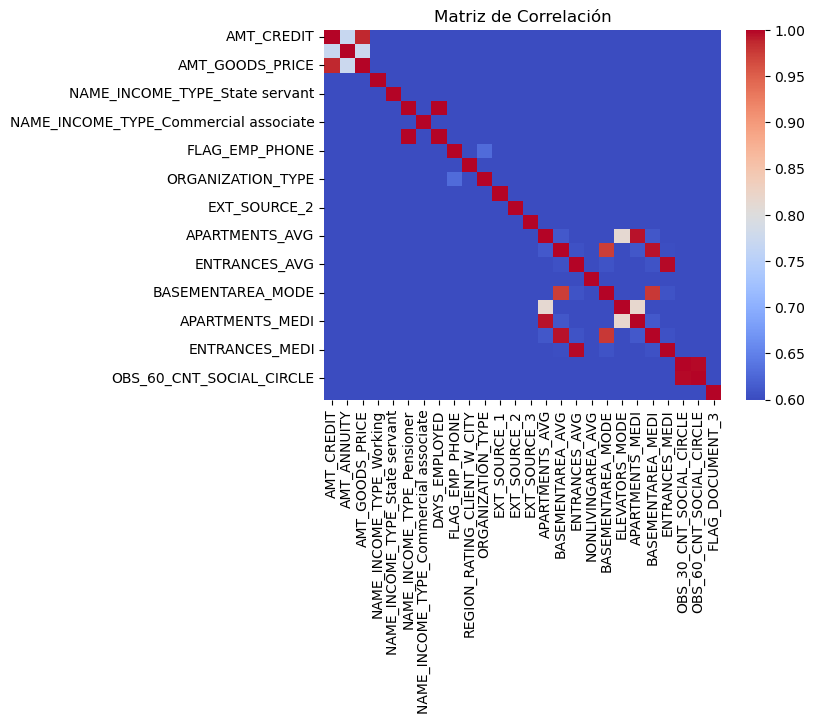

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=False, vmin=0.6, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
new_corr = correlation_matrix.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

,level_0,level_1,correlation
215,FLAG_EMP_PHONE,DAYS_EMPLOYED,0.999784
213,FLAG_EMP_PHONE,NAME_INCOME_TYPE_Pensioner,0.999500
187,DAYS_EMPLOYED,NAME_INCOME_TYPE_Pensioner,0.999489
647,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998378
588,ENTRANCES_MEDI,ENTRANCES_AVG,0.996899
534,APARTMENTS_MEDI,APARTMENTS_AVG,0.995028
561,BASEMENTAREA_MEDI,BASEMENTAREA_AVG,0.994900
52,AMT_GOODS_PRICE,AMT_CREDIT,0.986484
564,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,0.977616
483,BASEMENTAREA_MODE,BASEMENTAREA_AVG,0.973741


Como se puede ver hay unas cuantas variables que están relacionadas casi al 100%. Voy a ir seleccionando en cada pareja de variables la que voy a eliminar en función de: 
- Cual es más difícil de interpretar --> 'FLAG_EMP_PHONE'
- Que información es menos útil, por ejemplo he decidod eliminar lo casos de '_MODE'

Después de realizar esto, voy a volver a tirar el modelo y evaluaré si existe algún tipo de mejora

In [27]:
lista_eliminar = ['FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner', 'OBS_30_CNT_SOCIAL_CIRCLE', 'ENTRANCES_MEDI', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
                  'AMT_GOODS_PRICE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MODE']

# Eliminar columnas del conjunto de entrenamiento y prueba
X_train_reduced = X_train.drop(columns=lista_eliminar)
X_test_reduced = X_test.drop(columns=lista_eliminar)
X_val_reduced = X_val.drop(columns=lista_eliminar)

assert list(X_train_reduced.columns) == list(X_test_reduced.columns), "Los conjuntos no tienen las mismas columnas."

In [28]:
print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val_reduced shape: {X_val_reduced.shape}")
print(f"y_val shape: {y_val.shape}")
print(X_val.shape)


X_train_reduced shape: (196806, 18)
y_train shape: (196806,)
X_val_reduced shape: (49202, 18)
y_val shape: (49202,)
(49202, 26)


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, f1_score, recall_score, fbeta_score

# Definir modelo
model = GaussianNB()

# Definir rango de búsqueda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validación cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperparámetros
grid_search.fit(X_train_reduced, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = best_model.predict(X_val_reduced)

# Calcular métricas adicionales
recall = recall_score(y_val, y_pred,) 
f2_score = fbeta_score(y_val, y_pred, beta=2) 
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validación: {accuracy:.4f}")
print(f"Recall en el conjunto de validación: {recall:.4f}")
print(f"F2-Score en el conjunto de validación: {f2_score:.4f}")

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.8765154070540891
Accuracy en el conjunto de validación: 0.8777
Recall en el conjunto de validación: 0.2467
F2-Score en el conjunto de validación: 0.2453

Matriz de confusión:
[[42216  3066]
 [ 2953   967]]


Los resultados conseguidos tras eliminar las columnas dependientes han empeorado claramente. La precisión ha aumentado en 7 puntos pero el recall, la medida objetivo, se ha desplomado. Voy a dejar este modelo aquí porque no veo forma de poder mejorarlo. 

Es un modelo simple que de primeras ha dado unos resultados que parecian buenos. El problema que presenta es precisamente eso, su simpleza, al no tener parámetros que ayuden a que se adapte a cada caso hace que la cantidad de mejora sea muy baja.

En base a esto y analizando un poco cada modelo, el que voy a tratar de optimizar ahora es el XGBoost. Aunque inicialmente sus resultados no destacan (la mayoría han tenido resultados similares) creo que su capacidad de optimización gracias a distintos parámetros puede hacer que se adapte bien al problema.

# 2. - Oversampling y undersampling

Antes de seguir, me he dado cuenta, de que en este caso, no se si será así siempre, es necesario realizar un tratamiento del desbalanceo. Los modelos son prácticamente inútiles con muestras tan desbalanceadas, de hecho, cuando se intentan añadir parámetros prácticamente siempre generan overfitting. 

Concluyendo, en este caso e imagino que en muchos otros, no se puede trabajar con un desbalanceo como el que hay, por ello voy a proceder a tratarlo. Existen 2 opciones a nivel general, undersampling y oversampling.

Considero que en este caso es necesario una combinación de ambas

Como tenemos una muestra muy desbalanceada, es casi imposible evitar el overfitting, por ello voy a probar a métodos de undersampling y oversampling.

- RandomOverSampler: Duplica aleatoriamente muestras de la clase minoritaria. Simple pero puede inducir sobreajuste.
- SMOTE (Synthetic Minority Oversampling Technique): Genera nuevos ejemplos sintéticos basados en vecinos cercanos. Es más robusto que el duplicado directo.
- ADASYN: Variante de SMOTE que enfoca la generación de ejemplos en las áreas más difíciles de clasificar.
- Borderline-SMOTE: Genera datos sintéticos cerca de las fronteras entre clases

In [94]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE solo al entrenamiento
smote = SMOTE(sampling_strategy=0.4, random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()/ len(y_train_resampled)


TARGET
0    0.714287
1    0.285713
Name: count, dtype: float64

In [96]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
X_resampled, y_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)
values = y_resampled.value_counts()/len(y_resampled)

print(len(y_train))
print(len(y_train_resampled))
print(len(y_resampled))
print(values)

196806
253212
175697
TARGET
0    0.588234
1    0.411766
Name: count, dtype: float64


# 3. - Evaluación modelos (clases balanceadas)

# 3.1. - Modelos Vanilla

In [97]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_resampled, y_resampled)   
    y_pred = pipe.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(X_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier()
model score: 0.920

    accuracy = 0.9203284419332547
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45282     0]
 [ 3920     0]]
    
LogisticRegression()
model score: 0.782

    accuracy = 0.7816755416446486
    precision = 0.18602724594992637
    recall = 0.5155612244897959
    f1_score = 0.2734036796536797
    confusion matrix:
    [[36439  8843]
 [ 1899  2021]]
    
GaussianNB()
model score: 0.467

    accuracy = 0.4674200235762774
    precision = 0.10192926045016078
    recall = 0.7278061224489796
    f1_score = 0.1788154183641492
    confusion matrix:
    [[20145 25137]
 [ 1067  2853]]
    
DecisionTreeClassifier()
model score: 0.765

    accuracy = 0.7653144181130849
    precision = 0.11998006975585451
    recall = 0.30714285714285716
    f1_score = 0.17255463991400932
    confusion matrix:
    [[36451  8831]
 [ 2716  1204]]
    
RandomForestClassifier()
model score: 0.886

    accuracy = 0.8858379740660949
    precision = 

# 3.2.1 - Árbol de decisión

In [131]:
def custom_recall_metric(y_val, y_pred):
    from sklearn.metrics import recall_score
    return recall_score(y_val, y_pred)

# Configurar el Pipeline
dt_pipeline = Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=seed))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],         # Función de evaluación para los nodos
    'classifier__max_depth': [3, 5, 10, None],           # Profundidad máxima del árbol
    'classifier__min_samples_split': [2, 5, 10],         # Número mínimo de muestras para dividir un nodo
    'classifier__min_samples_leaf': [1, 2, 4],           # Número mínimo de muestras en una hoja
    'classifier__max_features': [None, 'sqrt', 'log2'],  # Número máximo de características a considerar
    'classifier__max_leaf_nodes': [None, 10, 20, 50],    # Número máximo de nodos hoja
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    scoring= make_scorer(custom_recall_metric), 
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)
y_pred = CV.predict(X_val)


# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)
print(classification_report(y_val, y_pred))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.8s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.9s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.9s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__max_features=sqrt, classifier__max_leaf_nodes=20, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.9s
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__m

In [87]:
recall_score(y_val, y_pred)

0.07729591836734694

# 3.2.2. - XGBClassifier

In [ ]:
# Configurar el Pipeline
xgb_pipeline = Pipeline(steps=[('classifier', XGBClassifier( eval_metric='logloss'))])

# Definir el espacio de hiperparámetros

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],                 # Poca profundidad --> evitar overfitting
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],           # Fracción de datos usados por cada árbol
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],    #  Fracción de características usadas por árbol
    'classifier__min_child_weight': [1, 5, 10],
    'classifier__gamma': [0, 0.1, 0.2],
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)

CV.predict(X_val)

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

print(classification_report(y_val, y_pred))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=  10.7s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=  10.7s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=  10.7s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.2, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__min_child_weight=10, classifier__n_estimators=200, classifier__subsample=1.0; total time=  10.7s
[CV] END 

In [103]:
recall_score(y_val, y_pred)
accuracy_score(y_val,y_pred)

0.7572049916670054

# LightGMB

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Configurar el Pipeline
lgbm_pipeline = Pipeline(steps=[('classifier', LGBMClassifier(random_state=seed))])

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200, 300],       # Número de árboles
    'classifier__max_depth': [3, 5, 7, -1],           # Profundidad máxima (-1 para sin límite)
    'classifier__learning_rate': [0.01, 0.05, 0.1],   # Tasa de aprendizaje
    'classifier__subsample': [0.6, 0.8, 1.0],         # Fracción de datos para cada árbol
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],  # Fracción de características para cada árbol
    'classifier__min_child_samples': [10, 20, 30],    # Muestras mínimas en una hoja
    'classifier__num_leaves': [31, 50, 100],          # Número máximo de hojas en un árbol
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Número de combinaciones a probar
    cv=10,  # Validación cruzada
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)

y_pred_proba = CV.predict_proba(X_val)[:, 1]
threshold = 0.3  # Prueba valores como 0.3 o 0.4
y_pred = (y_pred_proba >= threshold).astype(int)


# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

# Reporte de clasificación
print(classification_report(y_val, y_pred))


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 65112, number of negative: 93015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5600
[LightGBM] [Info] Number of data points in the train set: 158127, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411770 -> initscore=-0.356652
[LightGBM] [Info] Start training from score -0.356652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

# 3.3. - Evaluación modelo final 

In [136]:
prob_predictions = CV.predict_proba(X_val)
print(prob_predictions)

[[0.67306216 0.32693784]
 [0.64397128 0.35602872]
 [0.71738304 0.28261696]
 ...
 [0.71738304 0.28261696]
 [0.72972973 0.27027027]
 [0.97802198 0.02197802]]


Text(45.722222222222214, 0.5, 'Actual')

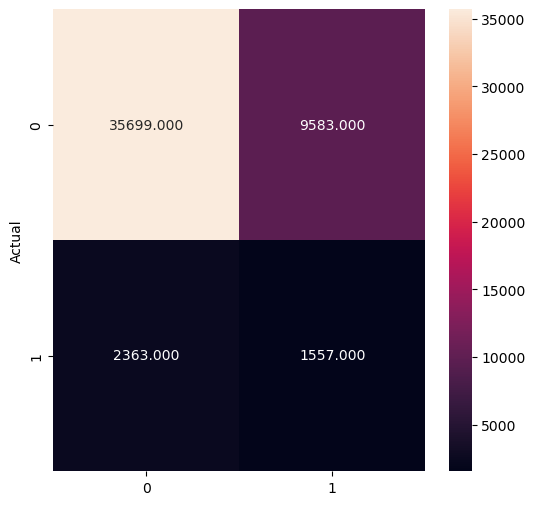

In [132]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.3f')
plt.ylabel('Actual')

Confusion matrix, without normalization
[[35699  9583]
 [ 2363  1557]]
Normalized confusion matrix
[[0.78837066 0.21162934]
 [0.60280612 0.39719388]]


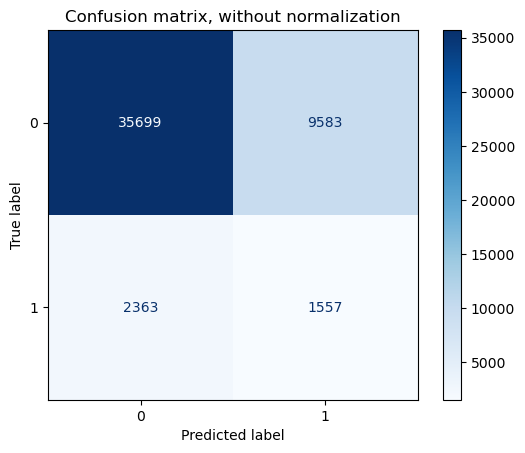

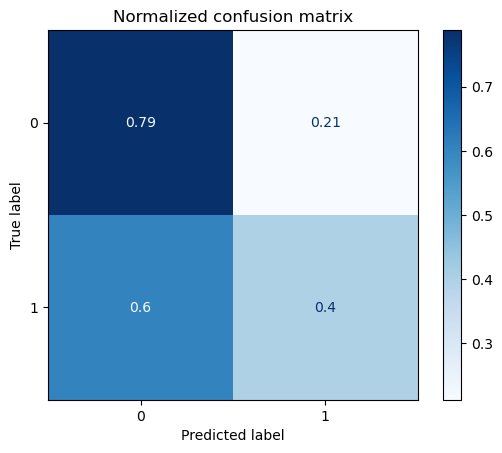

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(CV, X_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

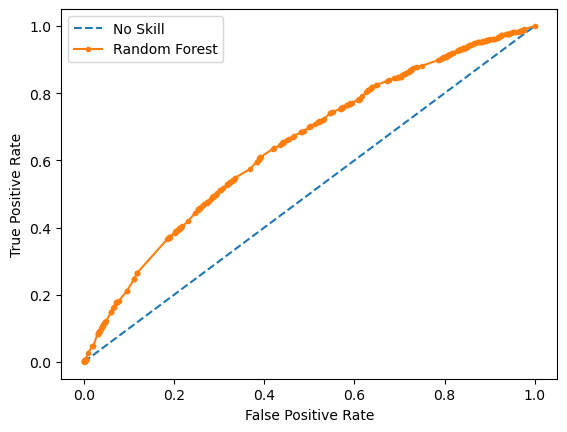

In [156]:
# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [161]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
ix= np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.359375, G-Mean=0.609


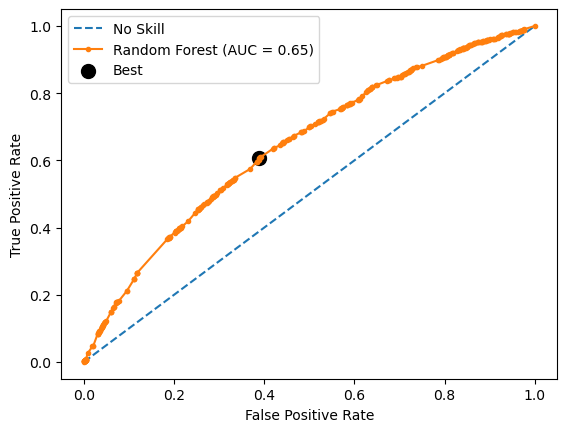

In [ ]:

# calculate AUC
roc_auc = roc_auc_score(y_val, yhat)


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')    ## Caso de aleatoriedad
plt.plot(fpr, tpr, marker='.', label=f'Random Forest (AUC = {roc_auc:.2f})')   
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Precision Curve

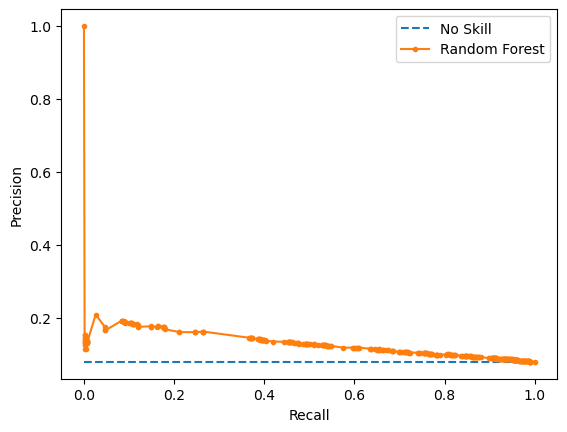

In [171]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, yhat)

# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

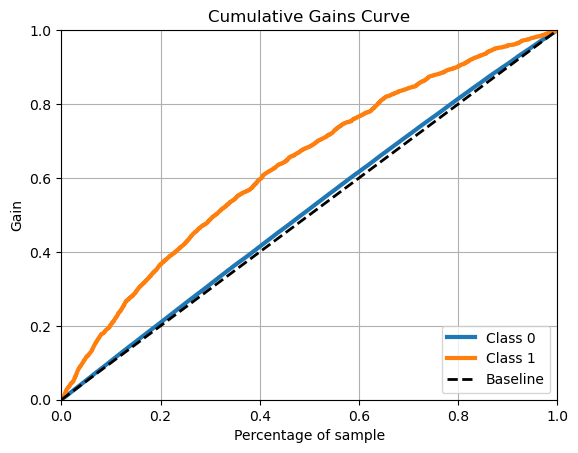

In [173]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(y_val, prob_predictions)
plt.show()

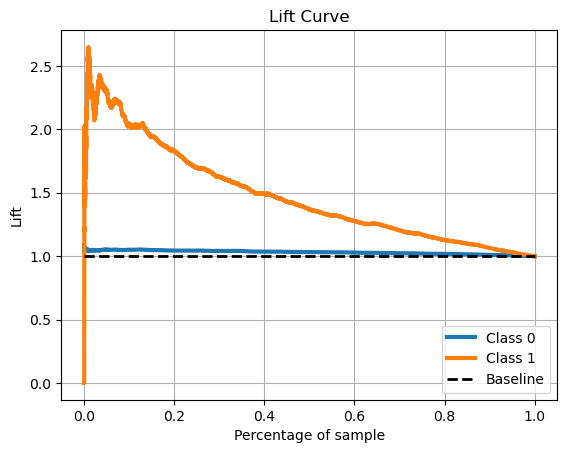

In [175]:
skplt.metrics.plot_lift_curve(y_val, prob_predictions)
plt.show()

# 4. - Explicabilidad

In [178]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [183]:
explainer = shap.TreeExplainer(CV.best_estimator_.named_steps['classifier'])


In [179]:
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [180]:
all_columns = get_feature_names(preprocessor)

NameError: name 'preprocessor' is not defined

In [ ]:
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [181]:
X_val.head()

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Commercial associate,DAYS_EMPLOYED,FLAG_EMP_PHONE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,ENTRANCES_AVG,NONLIVINGAREA_AVG,BASEMENTAREA_MODE,ELEVATORS_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,ENTRANCES_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_3
161368,-0.073930,0.874289,-0.092044,-1.033175,-0.274801,-0.468609,1.813187,-0.469038,0.468738,-2.051897,1.085138,1.386448,0.738741,-0.547240,-0.191390,-5.225548e-16,-7.877002e-16,-0.230883,-5.104426e-16,-0.356557,-0.196740,-2.619856e-16,-7.851344e-16,0.251833,0.261440,0.640008
177644,-1.098374,-1.329553,-1.032968,-1.033175,-0.274801,2.133976,-0.551515,2.133384,-2.133389,-0.063192,-1.342503,0.000000,0.728689,0.661828,-1.255804,-5.225548e-16,-7.877002e-16,-0.243309,-5.104426e-16,-0.356557,-1.242660,-2.619856e-16,-7.851344e-16,2.412176,2.440693,-1.562480
42295,-1.240956,-1.337650,-1.240704,0.967890,-0.274801,-0.468609,-0.551515,-0.459023,0.468738,-0.063192,-0.174153,-0.230180,1.353475,0.554383,-0.191390,-5.225548e-16,-7.877002e-16,-0.230883,-5.104426e-16,-0.356557,-0.196740,-2.619856e-16,-7.851344e-16,2.412176,2.440693,0.640008
161674,1.194505,0.315932,0.983297,0.967890,-0.274801,-0.468609,-0.551515,-0.455470,0.468738,-0.063192,0.635865,-1.752447,-2.219343,-0.725716,-0.191390,-5.225548e-16,-7.877002e-16,-0.230883,-5.104426e-16,-0.356557,-0.196740,-2.619856e-16,-7.851344e-16,-0.180235,-0.174411,0.640008
235457,-1.132218,-0.880502,-1.094067,-1.033175,-0.274801,2.133976,-0.551515,2.133384,-2.133389,-0.063192,-1.342503,0.000000,0.753822,0.915999,-1.217051,-1.667687e+00,-1.637255e+00,-0.305438,-1.612495e+00,-0.356557,-1.202974,-1.663108e+00,-1.624805e+00,-0.612304,-0.610261,0.640008


In [184]:
shap_values = explainer.shap_values(X_val)

In [185]:
X_val.iloc[0,:]

AMT_CREDIT                              -7.392974e-02
AMT_ANNUITY                              8.742889e-01
AMT_GOODS_PRICE                         -9.204404e-02
NAME_INCOME_TYPE_Working                -1.033175e+00
NAME_INCOME_TYPE_State servant          -2.748005e-01
NAME_INCOME_TYPE_Pensioner              -4.686088e-01
NAME_INCOME_TYPE_Commercial associate    1.813187e+00
DAYS_EMPLOYED                           -4.690384e-01
FLAG_EMP_PHONE                           4.687378e-01
REGION_RATING_CLIENT_W_CITY             -2.051897e+00
ORGANIZATION_TYPE                        1.085138e+00
EXT_SOURCE_1                             1.386448e+00
EXT_SOURCE_2                             7.387413e-01
EXT_SOURCE_3                            -5.472402e-01
APARTMENTS_AVG                          -1.913902e-01
BASEMENTAREA_AVG                        -5.225548e-16
ENTRANCES_AVG                           -7.877002e-16
NONLIVINGAREA_AVG                       -2.308827e-01
BASEMENTAREA_MODE           

In [186]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_val.iloc[0,:])

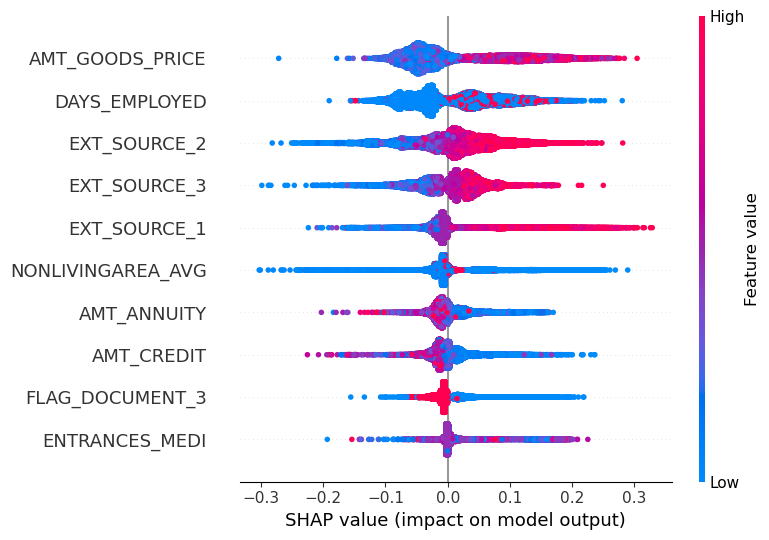

In [187]:
shap.summary_plot(shap_values[0], features=X_val, max_display=10)